### Recurrent Neural Networks with pytorch

In this example we are going to see how we can implement RNN. In the following code we will be using imdb data set to perform Sentiment analysis

Before we get started we need to install pytorch Download pytorch with the following LINK Also Go through Rahul_NLP_RR.md for concepts of MD

###### we will be using pytorch to impement basic RNN model

Here we will be doing Sentiment analysis on IMDB data set, the output will either be 0 a negitive sentiment or 1 a positive sentiment.

##### Our frist task is to import packeges that we are going to use

We will be importing 2 Packages

- torch
- torchtext
    - torchtext consists of data processing utilities and some popular datasets of naturl launguage
    
One of the main concepts of TorchText is the Field. These define how your data should be processed. In our sentiment classification task the data consists of both the raw string of the review and the sentiment, either "pos" or "neg".

In [ ]:
import torch
from torchtext import data

torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

TEXT = data.Field()
LABEL = data.LabelField(dtype = torch.float)

##### Train test split

Similar to deep learning where we split data into train and test data and in each as X and Y, where X had the data and Y had a label corresponding to that perticual data. Here we use the IMDB data set and split them into train and test. Here TEXT is similar to X and LABEL is similar to Y

In [ ]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 194
Number of testing examples: 50


In [ ]:
print(vars(train_data.examples[5]))

{'text': ['This', "isn't", 'the', 'comedic', 'Robin', 'Williams,', 'nor', 'is', 'it', 'the', 'quirky/insane', 'Robin', 'Williams', 'of', 'recent', 'thriller', 'fame.', 'This', 'is', 'a', 'hybrid', 'of', 'the', 'classic', 'drama', 'without', 'over-dramatization,', 'mixed', 'with', "Robin's", 'new', 'love', 'of', 'the', 'thriller.', 'But', 'this', "isn't", 'a', 'thriller,', 'per', 'se.', 'This', 'is', 'more', 'a', 'mystery/suspense', 'vehicle', 'through', 'which', 'Williams', 'attempts', 'to', 'locate', 'a', 'sick', 'boy', 'and', 'his', 'keeper.<br', '/><br', '/>Also', 'starring', 'Sandra', 'Oh', 'and', 'Rory', 'Culkin,', 'this', 'Suspense', 'Drama', 'plays', 'pretty', 'much', 'like', 'a', 'news', 'report,', 'until', "William's", 'character', 'gets', 'close', 'to', 'achieving', 'his', 'goal.<br', '/><br', '/>I', 'must', 'say', 'that', 'I', 'was', 'highly', 'entertained,', 'though', 'this', 'movie', 'fails', 'to', 'teach,', 'guide,', 'inspect,', 'or', 'amuse.', 'It', 'felt', 'more', 'like', 'I', 'was', 'watching', 'a', 'guy', '(Williams),', 'as', 'he', 'was', 'actually', 'performing', 'the', 'actions,', 'from', 'a', 'third', 'person', 'perspective.', 'In', 'other', 'words,', 'it', 'felt', 'real,', 'and', 'I', 'was', 'able', 'to', 'subscribe', 'to', 'the', 'premise', 'of', 'the', 'story.<br', '/><br', '/>All', 'in', 'all,', "it's", 'worth', 'a', 'watch,', 'though', "it's", 'definitely', 'not', 'Friday/Saturday', 'night', 'fare.<br', '/><br', '/>It', 'rates', 'a', '7.7/10', 'from...<br', '/><br', '/>the', 'Fiend', ':.'], 'label': 'pos'}

### DEV / Validation set

We will be splitting the training data into dev/validation sets

Dev sets are used to verify which model works best on the data.

There are many diffrent architectures in the RNNs and we need to find out what works best with our datasets and hence testing the model on large datasets will take a lot of time. This is where the dev set comes into picture If the current model dosen't work that well then we can try out LSTM RNN and many such model that provide better results. Since dev set consists small data sets it will be easy to implement the new changes in the model on it and validate which technique works best

In [ ]:
import random
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
print(f'No training samples: {len(train_data)}')
print(f'No validation samples: {len(valid_data)}')
print(f'No testing samples: {len(test_data)}')

No training samples: 17500
No validation samples: 7500
No testing samples: 25000

Now we have to build a Vocab and we will be using One-hot Vector
We do this as our RNN model cannot operate on strings. So we need to represent them in numbers. Each index is used to construct a one-hot vector for each word. A one-hot vector is a vector where all of the elements are 0, except one, which is 1, and dimensionality is the total number of unique words in your vocabulary, commonly denoted by V.

The image below represents the one-hot vetor

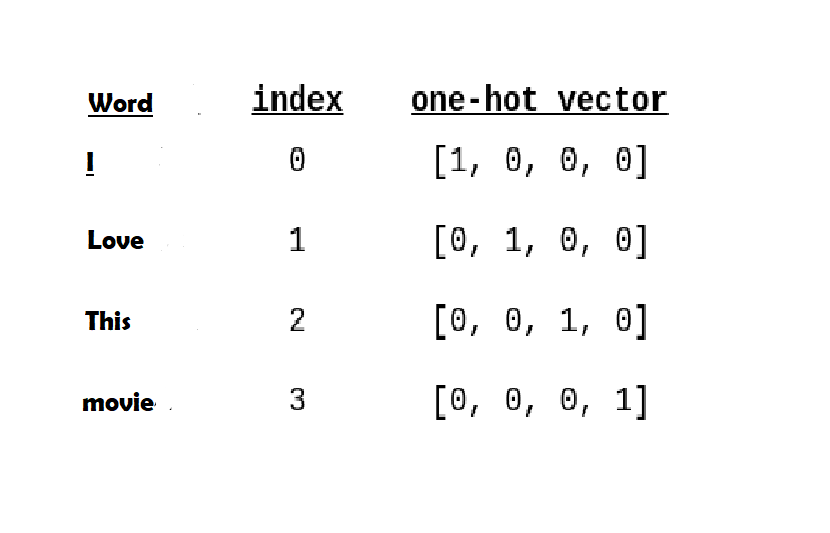

In [ ]:
Max_size_vcb = 25_000
TEXT.build_vocab(train_data, max_size = Max_size_vcb)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 201637), ('a', 108267), ('and', 106782), ('of', 99982), ('to', 92808), ('is', 72305), ('in', 59801), ('I', 45880), ('that', 45107), ('this', 40094), ('it', 38059), ('/><br', 35752), ('was', 32706), ('as', 29668), ('with', 29022), ('for', 28896), ('The', 23668), ('but', 23604), ('on', 21550), ('movie', 21368)]

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'I']

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})

In [ ]:
BATCH_SIZE = 64

device = torch.device('cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

### Building our RNN model

here we will be building simple RNN model and check how the model works with our datasets

We Will be importing the neural networks lib from torch. (This lib consists built in RNN module and we will be using it) If the module dosen't show good results then we can go with other RNN models such as LSTM-RNN etc.. We can also use the bidirectional Rnn model

###### In the code below

- Here the RNN class is a sub-class of nn.Module
- The three layers that we have initialized in the model are an embedding layer, our RNN, and a linear layer. All layers have their parameters initialized to random values
    - The embedding layer is used to transform the One Hot vector into a dense embedding vector
    - RNN which takes in our dense vector and the previous hidden state $h_{t-1}$, which it uses to calculate the next hidden state, $h_t$.
- The linear layer takes the final hidden state and feeds it through a fully connected layer, $f(h_T)$, transforming it to the correct output dimension.
- The RNN returns 2 tensors, output and hidden. output is the concatenation of the hidden state from every time step, whereas hidden is simply the final hidden state. We verify this using the assert statement.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,592,105 trainable parameters

### Model optimization

Similar to the backward prop perfomed in Deep learning by using optimization algoritmns such as gradient descent, RMS prop, ADAM here we are using socastic gradient descent

For this we need to import the optim module from pytorch (click on the LINK to know more)

We need to specify the models parameters and the learning rate. I have used a learning rate of 0.001

The function is fed to the sigmoid layer and then the output is generated between 0 and 1. if the output is greater than 0.5 then the output will be 1 else 0.

### Cost function

Our model has to output either 0 or 1. for this we need to use the sigmoid function, similar to the logestic regression performed by the DL model. Then we need to calculate the loss

The 0 or 1 indecates if the model is positive or negitive sentiment

Here we use BCEwithLogitsLoss to perfom both the sigmoid and calculate the loss using the Cross entropy

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def accur(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

We feed the batch of sentences, batch.text, into the model. The squeeze is needed as the predictions are initially size [batch size, 1], and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size [batch size].

- The loss and accuracy are then calculated using our predictions and the labels, batch.label, with the loss being averaged over all examples in the batch.

- We calculate the gradient of the parameters by loss.backward(), and then update the parameters using the gradients and optimizer algorithm with optimizer.step().

- The loss and accuracy is accumulated across the epoch, the .item() method is used to extract a scalar from a tensor which only contains a single value.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Dev is similar to the train function but we wont be updating the parameters model.eval() this turns off dropout and batch normalization. gradients are not calculated on PyTorch operations inside the with no_grad() block.

In [ ]:
def dev(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = accur(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Now all we do is train the model with multiple itterations or epochs. In each step of training the model both the forward and the optimization takes place and the parameters get updated

###### Keep the epoch_count for 6 or above, I've only kept the count to one because it takes a lot of time to run on my device

In [ ]:
Epoch_count = 1

best_valid_loss = float('inf')

for epoch in range(Epoch_count):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = dev(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 13s
	Train Loss: 0.694 | Train Acc: 50.27%
	 Val. Loss: 0.695 |  Val. Acc: 49.22%

### Conclusion

We can observe that our model is not doing well on the training set, this shows that the is Bias and we need to reduce the bias this can be done by:

    - providing more data to the training set
    - Using LSTM-RNN insted of basic RNN
    - Regularization for improving the accuracy of the dev/velidation set
    - Using Bidirectional RNN
By implementing all of this to our model we will be able to improve its performance